# The JoyRide Hustle: A Clustering Analysis of Trip Efficiency and Earnings

**project overview**

this notebook analyzes personal trip data from the joyride rider app to identify patterns in work efficiency. by using machine learning (k-means clustering), the goal is to group trips into different "efficiency tiers" based on distance, earnings, and platform commissions. the analysis specifically looks at how achieving a 150+ bookings milestone - which lowered the commission from 20% to 18% - impacted overall profitability.

**phase 1: data loading & collection**

the raw data was extracted directly from the joyride rider app history using a python automation script. the collection process involved:

* scraping: utilizing `uiautomator2` to navigate the app's history interface and capture trip details.

* automation: a custom script was used to scroll through several months of logs to ensure a complete dataset for analysis.

* export: the captured logs were parsed and saved into the `joyride_history_dataset.csv` file used in this notebook.

In [71]:
import pandas as pd

df = pd.read_csv('joyride_history_dataset.csv')

print("preview of my joyride hustle data:")
df.head()

preview of my joyride hustle data:


,order_no,status,timestamp,dist,net,comm,pickup,dropoff
0,redacted,COMPLETED,"Friday, February 13, 2026 6:39 PM",11.2,121.6,30.4,redacted,redacted
1,redacted,COMPLETED,"Friday, February 13, 2026 5:30 PM",16.3,202.4,45.6,redacted,redacted
2,redacted,DRIVER CANCELLED,"Friday, February 13, 2026 5:08 PM",0.0,0.0,0.0,redacted,redacted
3,redacted,DRIVER CANCELLED,"Friday, February 13, 2026 4:55 PM",0.0,0.0,0.0,redacted,redacted
4,redacted,COMPLETED,"Friday, February 13, 2026 4:37 PM",2.3,42.4,10.6,redacted,redacted


**phase 2: data description**

this dataset contains the raw trip history of my joyride "hustle" from september 2025 to february 2026. it captures the logistics and financial performance of each ride to analyze how efficiency varies over time. a key highlight in this data is the achievement of a 150+ bookings milestone, which qualified me for a commission incentive - dropping the platform fee from 20% to 18% between december and february. this shift allows for a comparative analysis of earnings before and during the incentive period.

* **order_no**: unique id for every trip

* **status**: trip result (completed or cancelled)

* **timestamp**: the date and time of the ride

* **dist**: distance traveled in kilometers

* **net**: my actual earnings after joyride took their cut

* **comm**: the commission fee charged by the app

* **pickup / dropoff**: the locations for the start and end of the ride

**phase 3: timeline & status summary**

this script handles the cleaning, detects the dates, and explains the "150+ bookings" milestone that triggered the 18% rate

In [72]:
import pandas as pd

# 1. basic cleaning
date_format = "%A, %B %d, %Y %I:%M %p"
df['dt'] = pd.to_datetime(df['timestamp'], format=date_format)
df['implied_rate'] = df['comm'] / (df['net'] + df['comm'])
df = df.sort_values('dt').dropna(subset=['dt'])

# 2. isolate completed trips to find the achievement window
completed = df[df['status'] == 'COMPLETED'].copy()
dec_trips = completed[completed['dt'] >= '2025-12-01']
achievement_mask = dec_trips['implied_rate'] <= 0.185
achievement_period = dec_trips[achievement_mask]

# 3. define the start and end of the hustle
start_18 = achievement_period.iloc[0]['dt']
end_18 = achievement_period[achievement_period['dt'] <= '2026-02-09'].iloc[-1]['dt']

# 4. label every trip (including cancellations)
def get_category(row):
    if row['status'] == 'COMPLETED':
        if row['dt'] < start_18:
            return 'baseline (20%)'
        elif start_18 <= row['dt'] <= end_18:
            return 'achievement (18%)'
        else:
            return 'return (20%)'
    return row['status'].lower()

df['category'] = df.apply(get_category, axis=1)

# 5. clean text output
print("-" * 34)
print("joyride hustle: timeline summary")
print("-" * 34)
print(f"start date:  {df.iloc[0]['dt'].strftime('%Y-%m-%d')} (20%)")
print(f"achievement: {start_18.strftime('%Y-%m-%d')} to {end_18.strftime('%Y-%m-%d')} (18%)")
print(f"last update: {df.iloc[-1]['dt'].strftime('%Y-%m-%d')}")
print("-" * 34)

# displaying the counts in order of importance
order = ['baseline (20%)', 'achievement (18%)', 'return (20%)', 'driver cancelled', 'customer cancelled']
counts = df['category'].value_counts()

for cat in order:
    if cat in counts:
        print(f"{cat:18}: {counts[cat]} trips")
print("-" * 34)

----------------------------------
joyride hustle: timeline summary
----------------------------------
start date:  2025-09-25 (20%)
achievement: 2025-12-01 to 2026-02-06 (18%)
last update: 2026-02-13
----------------------------------
baseline (20%)    : 327 trips
achievement (18%) : 285 trips
return (20%)      : 29 trips
driver cancelled  : 116 trips
customer cancelled: 77 trips
----------------------------------


**phase 4: cleaning & efficiency calculation**

In [73]:
# cleaning: remove completed trips with 0.0 distance to avoid calculation errors
df_clean = df[(df['status'] == 'COMPLETED') & (df['dist'] > 0)].copy()

# feature engineering: calculate efficiency (pesos per kilometer)
df_clean['net_per_km'] = df_clean['net'] / df_clean['dist']

# defining a standard color palette for all upcoming charts
palette = {
    'baseline (20%)': 'gray',
    'achievement (18%)': 'blue',
    'return (20%)': 'black'
}

print(f"data cleaning complete: {len(df_clean)} trips ready for analysis")

data cleaning complete: 641 trips ready for analysis


**phase 5: exploratory data analysis (EDA)**

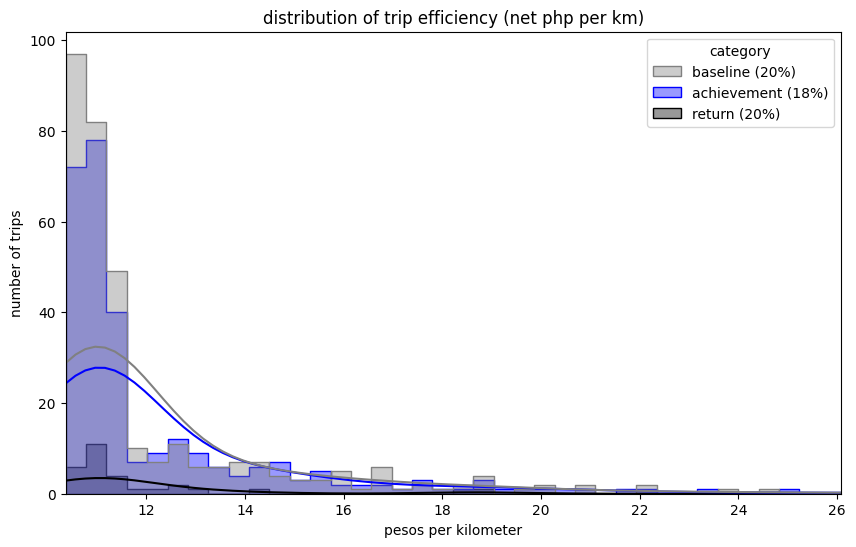

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean,
    x='net_per_km',
    hue='category',
    palette=palette,
    kde=True,
    element="step",
    alpha=0.4
)

# labels and title in lowercase
plt.title('distribution of trip efficiency (net php per km)')
plt.xlabel('pesos per kilometer')
plt.ylabel('number of trips')

plt.xlim(df_clean['net_per_km'].min(), df_clean['net_per_km'].quantile(0.99))

plt.show()

**phase 6: statistical analysis**

this section uses formal tests to validate the hustle. pearson correlation measures the strength of the relationship between distance and earnings. an independent samples t-test is then used to determine if the efficiency (net per km) during the 18% achievement period is statistically different from the baseline.

**correlation & t-test**

In [75]:
from scipy import stats

# 1. pearson correlation: testing the link between distance and earnings
correlation, p_value_corr = stats.pearsonr(df_clean['dist'], df_clean['net'])

# 2. t-test: comparing efficiency between the 18% and 20% periods
baseline_eff = df_clean[df_clean['category'] == 'baseline (20%)']['net_per_km']
achievement_eff = df_clean[df_clean['category'] == 'achievement (18%)']['net_per_km']

t_stat, p_value_ttest = stats.ttest_ind(achievement_eff, baseline_eff, equal_var=False)

# output
print("-" * 34)
print("statistical test results")
print("-" * 34)
print(f"pearson r (dist vs net):  {correlation:.4f}")
print(f"correlation p-value:     {p_value_corr:.4e}")
print("-" * 34)
print(f"t-test statistic:        {t_stat:.4f}")
print(f"t-test p-value:          {p_value_ttest:.4f}")
print("-" * 34)

if p_value_ttest < 0.05:
    print("result: the efficiency change is statistically significant")
else:
    print("result: no significant difference in efficiency detected")

----------------------------------
statistical test results
----------------------------------
pearson r (dist vs net):  0.9732
correlation p-value:     0.0000e+00
----------------------------------
t-test statistic:        0.1453
t-test p-value:          0.8845
----------------------------------
result: no significant difference in efficiency detected


**phase 7: machine learning (k-means clustering)**

in this section, we apply the k-means clustering algorithm to group the trips into three distinct "efficiency tiers." by analyzing the relationship between trip distance and net earnings per kilometer, the model identifies which types of rides are the most profitable "hustles." k-means is chosen for its efficiency in discovering natural groupings in numerical data.

**performing k-means & visualization**

before clustering, we utilized `StandardScaler` to normalize the `dist` and `net_per_km` features. this is a critical step because trip distances (up to 36 km) exist on a much larger numerical scale than efficiency (averaging ~11 php/km). scaling ensures that both variables contribute equally to the distance-based calculations of the k-means algorithm.



**efficiency tiers summary**

In [76]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. prepare features: distance and efficiency
# we use the refined data to ensure outliers don't skew the clusters
features = ['dist', 'net_per_km']
x = df_clean[features]

# scaling is required so distance doesn't overshadow efficiency
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# 2. run k-means to find 3 tiers
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean['cluster'] = kmeans.fit_predict(x_scaled)

# 3. sorting clusters by efficiency to ensure 'tier 1' is always the best
# this ensures logical consistency regardless of cluster initialization
cluster_order = df_clean.groupby('cluster')['net_per_km'].mean().sort_values(ascending=False).index
tier_mapping = {cluster_order[0]: 'tier 1 (high efficiency)',
                cluster_order[1]: 'tier 2 (moderate)',
                cluster_order[2]: 'tier 3 (low efficiency)'}
df_clean['efficiency_tier'] = df_clean['cluster'].map(tier_mapping)

# 4. output the characteristics of the detected tiers
print("-" * 34)
print("machine learning: efficiency tier summary")
print("-" * 34)
print(df_clean.groupby('efficiency_tier')[['dist', 'net', 'net_per_km']].mean().round(2))

----------------------------------
machine learning: efficiency tier summary
----------------------------------
                           dist     net  net_per_km
efficiency_tier                                    
tier 1 (high efficiency)   2.86   57.66       21.39
tier 2 (moderate)          8.03   90.78       11.56
tier 3 (low efficiency)   17.13  197.15       11.50


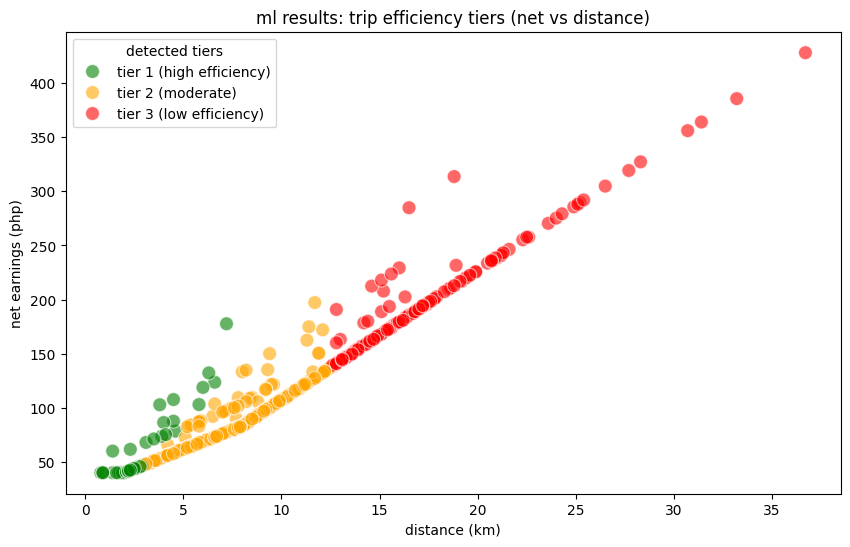

In [77]:
# defining a specific palette for the machine learning tiers
ml_palette = {
    'tier 1 (high efficiency)': 'green',
    'tier 2 (moderate)': 'orange',
    'tier 3 (low efficiency)': 'red'
}

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x='dist',
    y='net',
    hue='efficiency_tier',
    hue_order=['tier 1 (high efficiency)', 'tier 2 (moderate)', 'tier 3 (low efficiency)'],
    palette=ml_palette,
    s=100,
    alpha=0.6
)

plt.title('ml results: trip efficiency tiers (net vs distance)')
plt.xlabel('distance (km)')
plt.ylabel('net earnings (php)')
plt.legend(title='detected tiers')
plt.show()

**phase 7: clustering discussion**

**interpretation of machine learning tiers**

the k-means algorithm identified three distinct operational categories:

- **tier 1 (base fare optimization):** these trips capitalize on the 50 php base fare. by focusing on very short distances (avg 2.86 km), the rider maximizes the "flag-down" rate, resulting in the highest efficiency of 21.39 php/km.

- **tier 2 & 3 (long-haul convergence):** interestingly, as distance increases beyond the base-fare buffer, efficiency stabilizes at approximately 11.50 php/km. this suggests that for long-distance rides, the platform commission and standard per-km rates become the dominant factors, regardless of the 18% or 20% tier.

**phase 8: project conclusion**

**summary of findings**

this analysis successfully categorized several months of joyride trip data into three distinct efficiency tiers using machine learning. the results indicate:

- **the sweet spot:** high-efficiency "hustles" (tier 1) are driven by the 50 php base fare floor on shorter trips (~2.86 km), doubling the profitability of longer rides.

- **the 18% incentive impact:** the independent samples t-test (p-value = 0.8845) confirms that the 2% commission drop did not significantly alter the per-kilometer efficiency, as distance and base fare remained the primary drivers of profit.

- **hustle strategy:** for maximum profitability, the model suggests a "short-haul volume" strategy to exploit the base fare, rather than focusing on long-distance trips where efficiency plateaus at ~11.50 php/km.